In [1]:
#importing the necessary packages 

import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [2]:
# setting up the data paths

base_dir = '../input/state-farm-distracted-driver-detection/' # base directory
images_dir = os.path.join(base_dir,'imgs/')                   # images directory
test_dir = os.path.join(base_dir,'imgs/test/')                # test directory
train_dir = os.path.join(base_dir,'imgs/train/')              # train directory

driver_imgs_list = pd.read_csv(os.path.join(base_dir,'driver_imgs_list.csv'))  # images list csv 
sample_sub = pd.read_csv(os.path.join(base_dir,'sample_submission.csv'))       # sample submission

In [3]:
# lets look the image details 
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
# checking n unique classes avaliable 
classes = driver_imgs_list['classname'].unique()
classes

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

In [5]:
# keepsing some description for each class based on the driver position to have some clear idea 

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}



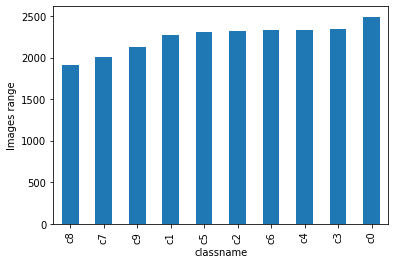

In [6]:
# lets check the class distribution 

driver_imgs_list.groupby('classname')['img'].count().sort_values().plot(kind='bar')
plt.ylabel('Images range')
plt.show()

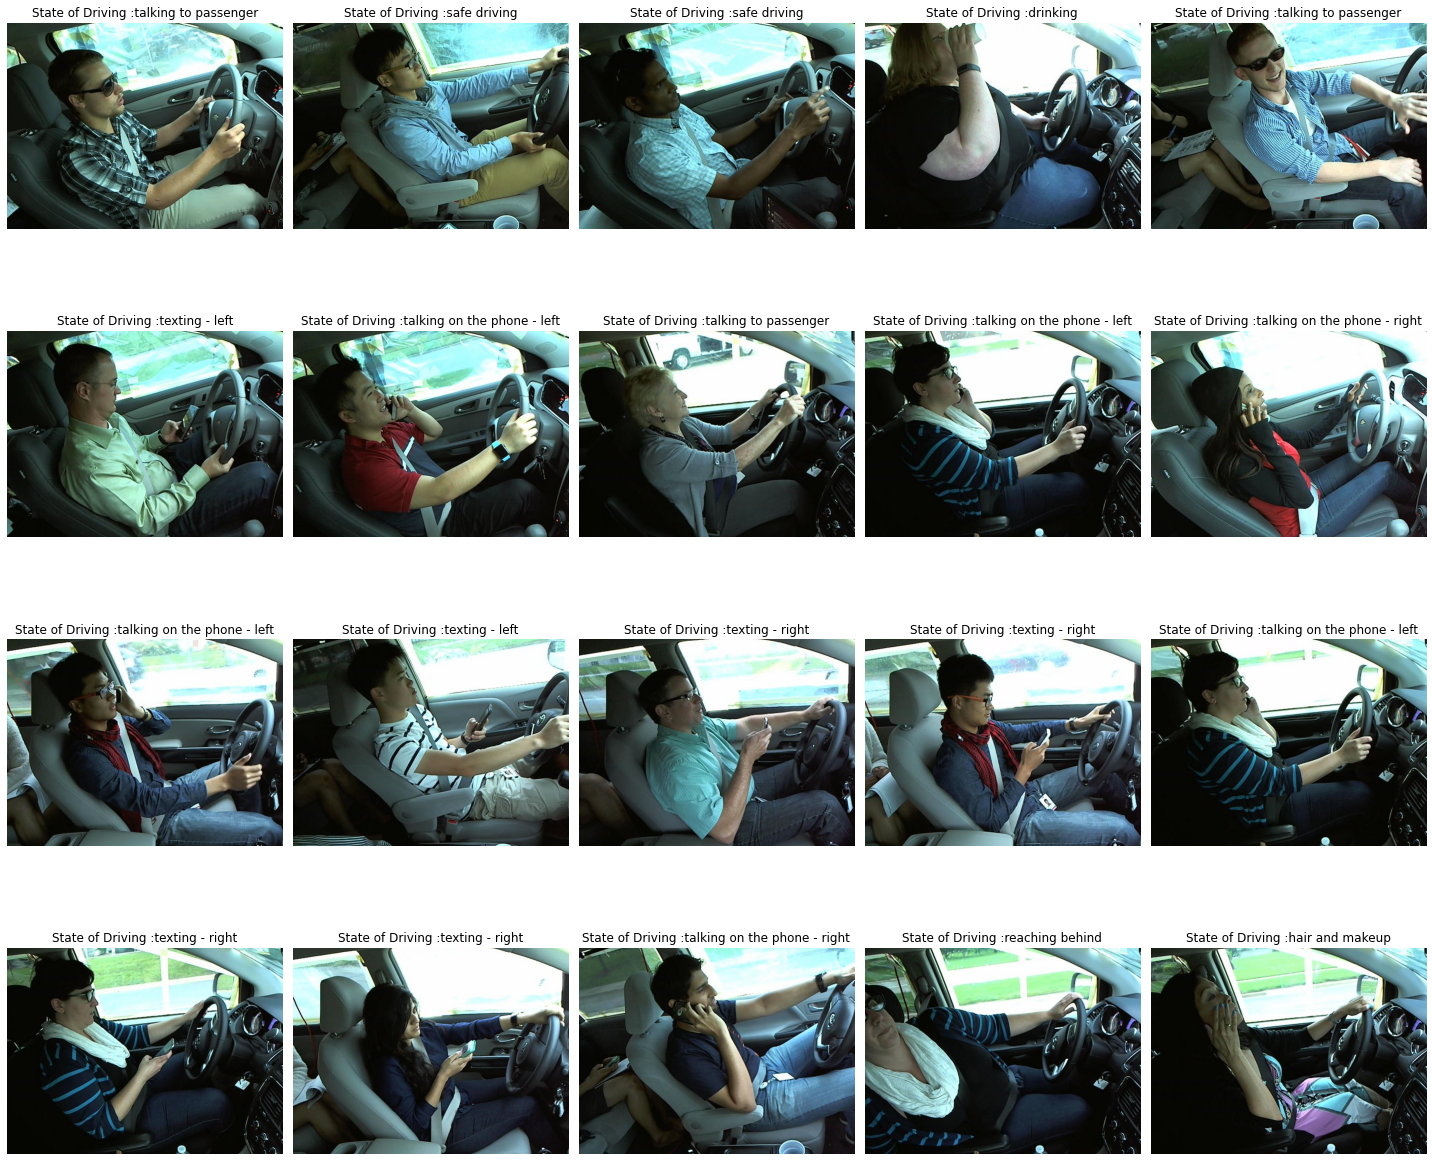

In [7]:
fig = plt.figure(figsize=(20,18)) # image size
cols,rows = 5,4                   

for i in range(1,cols*rows+1):
    pic_indx = random.randint(0,driver_imgs_list.shape[0])
    img = Image.open(os.path.join(base_dir,'imgs/train/')+str(driver_imgs_list.loc[pic_indx,'classname']+'/')
                    + str(driver_imgs_list.loc[pic_indx,'img']))
    fig.add_subplot(rows,cols,i)
    plt.imshow(img)
    plt.title('State of Driving :'+ class_def[driver_imgs_list.loc[pic_indx,'classname']])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# size of each image

img = Image.open('../input/state-farm-distracted-driver-detection/imgs/test/img_1.jpg')
print(img.size)


(640, 480)


In [9]:
# creating the train data generator and test data generator
 
image_size = (128,128)  # image shape
batch_size = 32
val_size = 0.2

train_data_gen = ImageDataGenerator(rescale=1./127,validation_split= val_size)
test_data_gen = ImageDataGenerator(rescale=1./127)

In [10]:
# defining the training parameters


train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = image_size,
                                                     batch_size = batch_size,
                                                     seed=42, 
                                                     shuffle=True,
                                                     subset='training')

val_generator =  train_data_gen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               batch_size = batch_size,
                                               seed=42, 
                                               shuffle=True,
                                               subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [11]:
# check the data for one batch

for data_batch,label_batch in train_generator:
    print(data_batch.shape)   # train batch
    print(label_batch.shape)  # label batch
    break

(32, 128, 128, 3)
(32, 10)


In [12]:
model = Sequential()                                                  # creating a sequential model
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3))) # taking units of 32 and filter of 3x3
model.add(MaxPooling2D(2,2))                                          # maxpool layer with 2x2 filter   
model.add(Conv2D(64,(3,3),activation='relu'))                         # taking units of 64 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))                        # taking units of 128 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu'))                        # taking units of 256 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(512,(3,3),activation='relu'))                        # taking units of 512 and filter of 3x3
model.add(MaxPooling2D(2,2))    
model.add(Flatten())                                                  # flattening the data to feed into to Dense layer
model.add(Dense(1024,activation='relu'))                              # taking units of 1024
model.add(Dense(512,activation='relu'))                               # taking units of 512 
model.add(Dense(128,activation='relu'))                               # taking units of 128
model.add(Dense(10,activation='softmax'))                             # output later with units of 10 since 10 labels

model.summary() # to print summary of model architecture

2022-03-11 06:21:01.067428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 06:21:01.153771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 06:21:01.154464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

2022-03-11 06:21:01.156396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 06:21:01.157526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 06:21:01.158228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 06:21:01.158861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [13]:
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
epochs = 10

history = model.fit(train_generator,
         steps_per_epoch=240,
         epochs=epochs,
         validation_data=val_generator,
         validation_steps=60
        )

2022-03-11 06:21:04.148912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-11 06:21:06.244392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


240/240 [==============================] - 100s 384ms/step - loss: 2.2517 - accuracy: 0.1202 - val_loss: 1.7879 - val_accuracy: 0.2911
Epoch 2/10
240/240 [==============================] - 72s 300ms/step - loss: 1.1235 - accuracy: 0.5682 - val_loss: 0.6584 - val_accuracy: 0.7432
Epoch 3/10
240/240 [==============================] - 61s 255ms/step - loss: 0.3892 - accuracy: 0.8716 - val_loss: 0.2981 - val_accuracy: 0.9099
Epoch 4/10
240/240 [==============================] - 55s 228ms/step - loss: 0.2325 - accuracy: 0.9266 - val_loss: 0.1651 - val_accuracy: 0.9490
Epoch 5/10
240/240 [==============================] - 52s 215ms/step - loss: 0.1642 - accuracy: 0.9497 - val_loss: 0.1327 - val_accuracy: 0.9589
Epoch 6/10
240/240 [==============================] - 49s 203ms/step - loss: 0.1235 - accuracy: 0.9635 - val_loss: 0.1329 - val_accuracy: 0.9635
Epoch 7/10
240/240 [==============================] - 47s 196ms/step - loss: 0.0916 - accuracy: 0.9728 - val_loss: 0.1308 - val_accuracy: 0.

In [15]:
model.save('distracted_driver_acc98.h5')

In [16]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

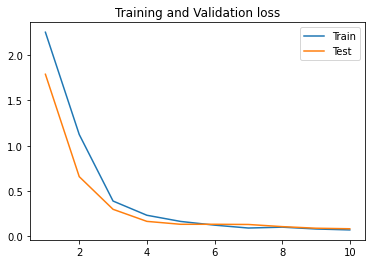

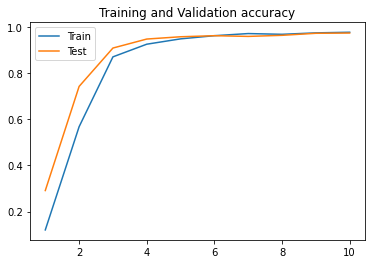

In [17]:
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

In [18]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    images_dir,
    shuffle = False,
    target_size = image_size,
    classes = ['test'],
    batch_size = 32
)

Found 79726 images belonging to 1 classes.


In [19]:
preds = model.predict(test_data)

In [20]:
# predictions on one batch of images

for data_batch,label_batch in test_data:
#     print(data_batch.shape,label_batch.shape)
    print(model.predict(data_batch).argmax(axis=1))
    break

[5 5 0 8 3 3 5 9 8 7 4 8 2 5 2 3 5 3 2 4 2 8 6 7 7 4 2 9 8 9 3 5]
